# Try running analyses with more flexible IGM models

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from cup1d.data import data_MPGADGET
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,sim_label=test_sim_label,
                                zmax=z_max,polyfit=(emu_type=="polyfit"))

### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)

In [5]:
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
emu_type="polyfit"
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.23 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [6]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=3
for i in range(n_igm):
    for par in ["tau"]:
    #for par in ["tau","sigT_kms","gamma","kF_kms"]:
        free_param_names.append('ln_{}_{}'.format(par,i))
# specify width of Gaussian prior on parameters (unit box)
prior=0.2 #None

In [19]:
from cup1d.nuisance import mean_flux_model
mf_model=mean_flux_model.MeanFluxModel(ln_tau_coeff=[0]*n_igm)
print(n_igm,mf_model.get_Nparam())

3 3


In [20]:
# setup theory
theory=lya_theory.Theory(zs=data.z,emulator=emu,mf_model_fid=mf_model)

In [11]:
free_param_names

['As', 'ns', 'ln_tau_0', 'ln_tau_1', 'ln_tau_2']

In [21]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior)

In [7]:
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior)

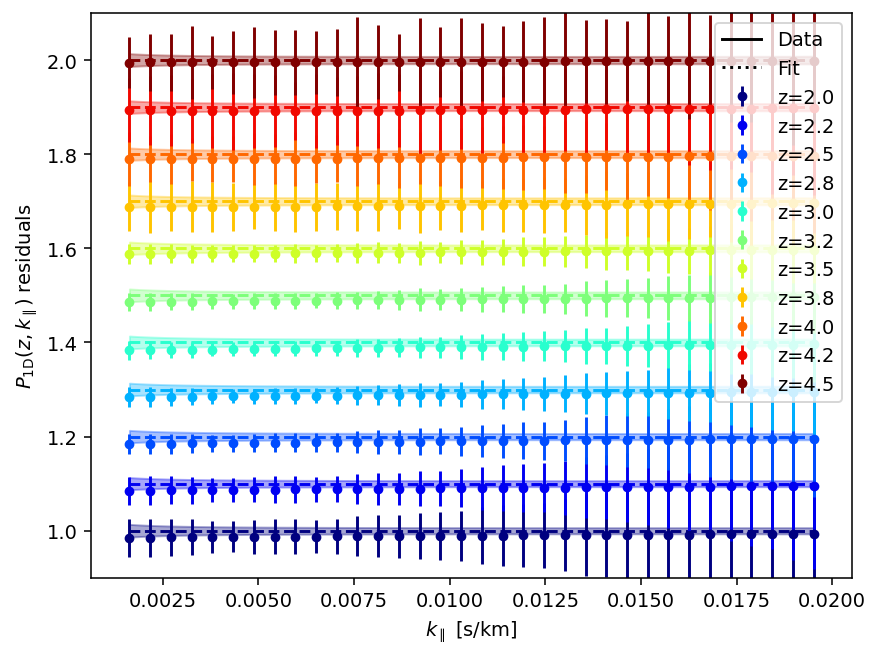

In [8]:
like.plot_p1d(residuals=True)

# Try iminuit minimizer

In [9]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [10]:
minimizer.minimize(compute_hesse=True)

will run migrad
will compute Hessian matrix


best-fit values = [0.4541961  0.46889929 0.51925832 0.50354467 0.48147702]


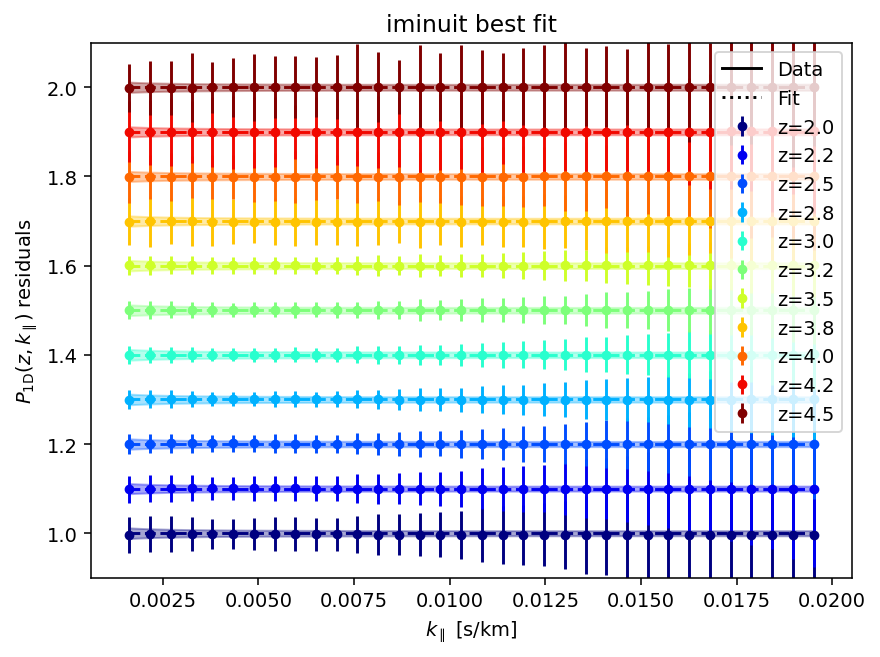

In [11]:
plt.figure()
minimizer.plot_best_fit()

compute true values for As ns


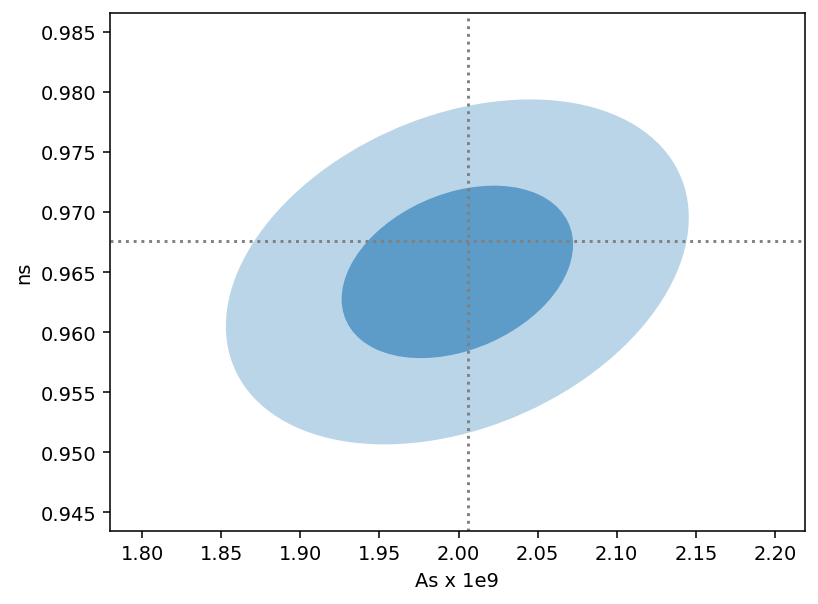

In [12]:
minimizer.plot_ellipses('As','ns')

In [16]:
minimizer.best_fit_value(pname='ln_tau_2')

cube values = [0.4541961  0.46889929 0.51925832 0.50354467 0.48147702]


-0.007409193604009434

### Access the actual minimizer object from iminuit

In [27]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 121.3                      │              Nfcn = 217              │
│ EDM = 2.32e-13 (Goal: 0.0001)    │            time = 1.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.454   │   0.033   │            │            │         │         │       │
│ 1 │ x1   │   0.47    │   0.04    │            │            │         │         │       │
│ 2 │ x2   │   0.52    │   0.06    │            │            │         │         │       │
│ 3 │ x3   │   0.50    │   0.05    │            │            │         │         │       │
│ 4 │ x4   │   0.48    │   0.17    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │   0.00111  0.000471  -0.00174  0.000169   0.00148 │
│ x1 │  0.000471   0.00202  -0.00155 -0.000739   0.00173 │
│ x2 │  -0.00174  -0.00155   0.00338  5.07e-05  -0.00398 │
│ x3 │  0.000169 -0.000739  5.07e-05   0.00258   -0.0014 │
│ x4 │   0.00148   0.00173  -0.00398   -0.0014    0.0277 │
└────┴───────────────────────────────────────────────────┘

In [14]:
#minimizer.minimizer.draw_mncontour("x0", "x1")

In [15]:
#minimizer.minimizer.draw_mnprofile("x0")